In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Polygon
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

df = pd.read_csv("data/Location_of_warehouses_Bangalore.csv")
# these two are way outside the city
df = df[df['Sl.no'].apply(lambda x: x not in {45, 46})].reset_index(drop=True).drop(columns='Sl.no', axis=1)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(
        df['Longitude (E) (in degrees)'], df['Latitude (N) (in degrees)']),
)

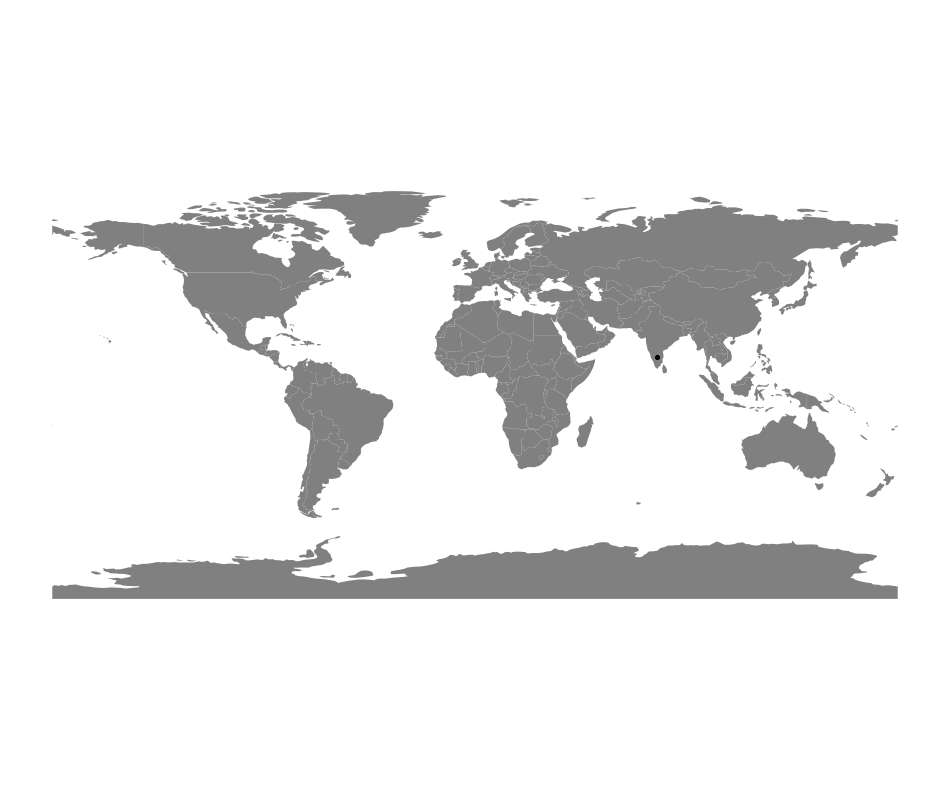

In [2]:
world: gpd.GeoDataFrame = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(12, 10))

world.plot(ax=ax, color="gray")
gdf.plot(ax=ax, markersize=3.5, color="black")
ax.axis("off")
plt.axis("equal")
plt.show()

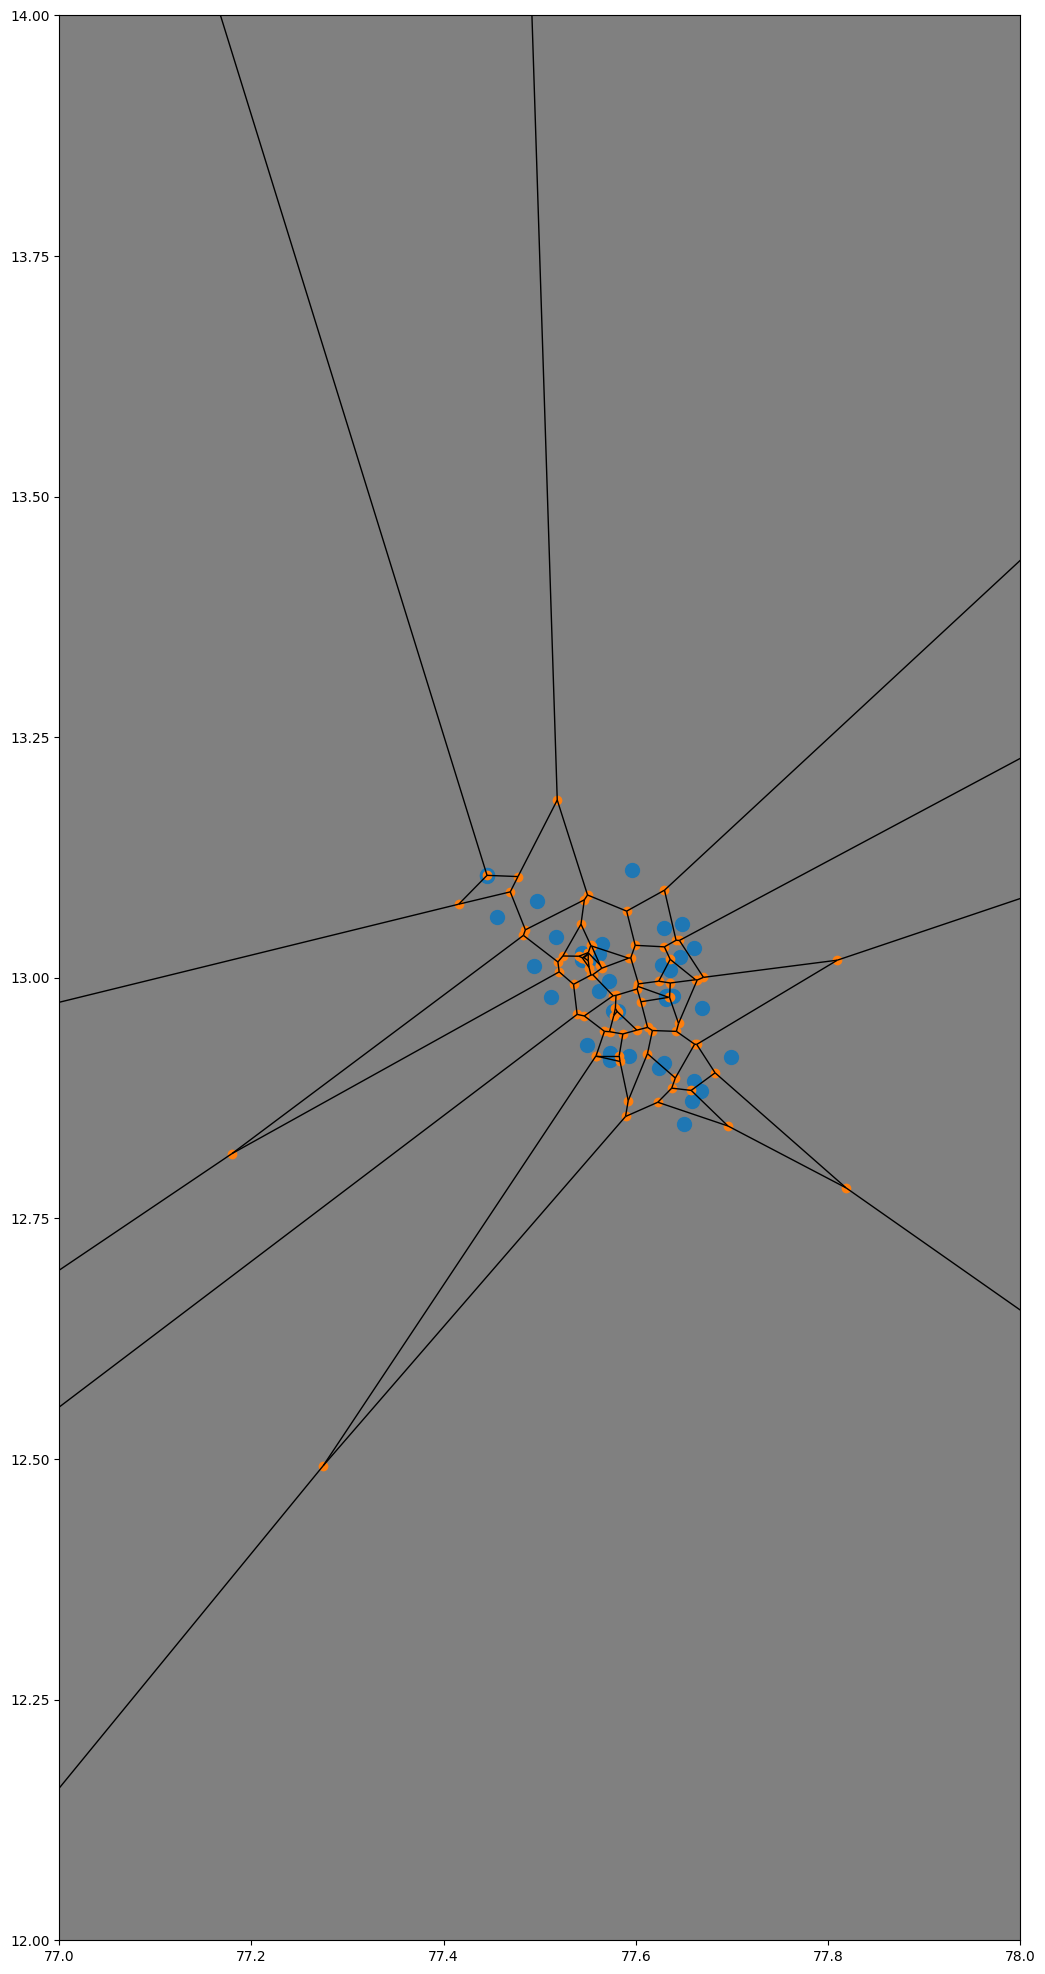

In [4]:
from matplotlib.axes import Axes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi, voronoi_plot_2d
# world_poly = Polygon([(-180, 90), (180, 90) , (180, -90), (-180, -90)])
# gdf_proj = gdf.to_crs(crs=3395)

boundary_shape = unary_union(world.geometry)
# boundary_shape = world_poly
coords = points_to_coords(gdf.geometry)
# coords = points_to_coords(gdf.set_crs(epsg=3995).geometry)

vor = Voronoi(coords, incremental=True)
fig, ax = plt.subplots(figsize=(25, 25))


def voronoi_plot_2d(vor: Voronoi, ax: Axes, **kw):
    from matplotlib.collections import LineCollection

    if vor.points.shape[1] != 2:
        raise ValueError("Voronoi diagram is not 2-D")

    if kw.get('show_points', True):
        point_size = kw.get('point_size', None)
        ax.plot(vor.points[:, 0], vor.points[:, 1], '.', markersize=point_size)
    if kw.get('show_vertices', True):
        ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'o')

    line_colors = kw.get('line_colors', 'k')
    line_width = kw.get('line_width', 1.0)
    line_alpha = kw.get('line_alpha', 1.0)

    center = vor.points.mean(axis=0)
    ptp_bound = vor.points.ptp(axis=0)

    finite_segments = []
    infinite_segments = []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            finite_segments.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            if (vor.furthest_site):
                direction = -direction
            far_point = vor.vertices[i] + direction * 270
            infinite_segments.append([vor.vertices[i], far_point])

    ax.add_collection(LineCollection(
        finite_segments,
        colors=line_colors,
        lw=line_width,
        alpha=line_alpha,
        linestyle='solid'))
    ax.add_collection(LineCollection(
        infinite_segments,
        colors=line_colors,
        lw=line_width,
        alpha=line_alpha,
        linestyle='solid'))

    return ax.figure


world.plot(ax=ax, color="gray")
voronoi_plot_2d(vor, ax, point_size=20)
plt.xlim((77, 78))
plt.ylim((12, 14))
# plt.xlim((-180, 180))
# plt.ylim((-90, 90))
plt.show()


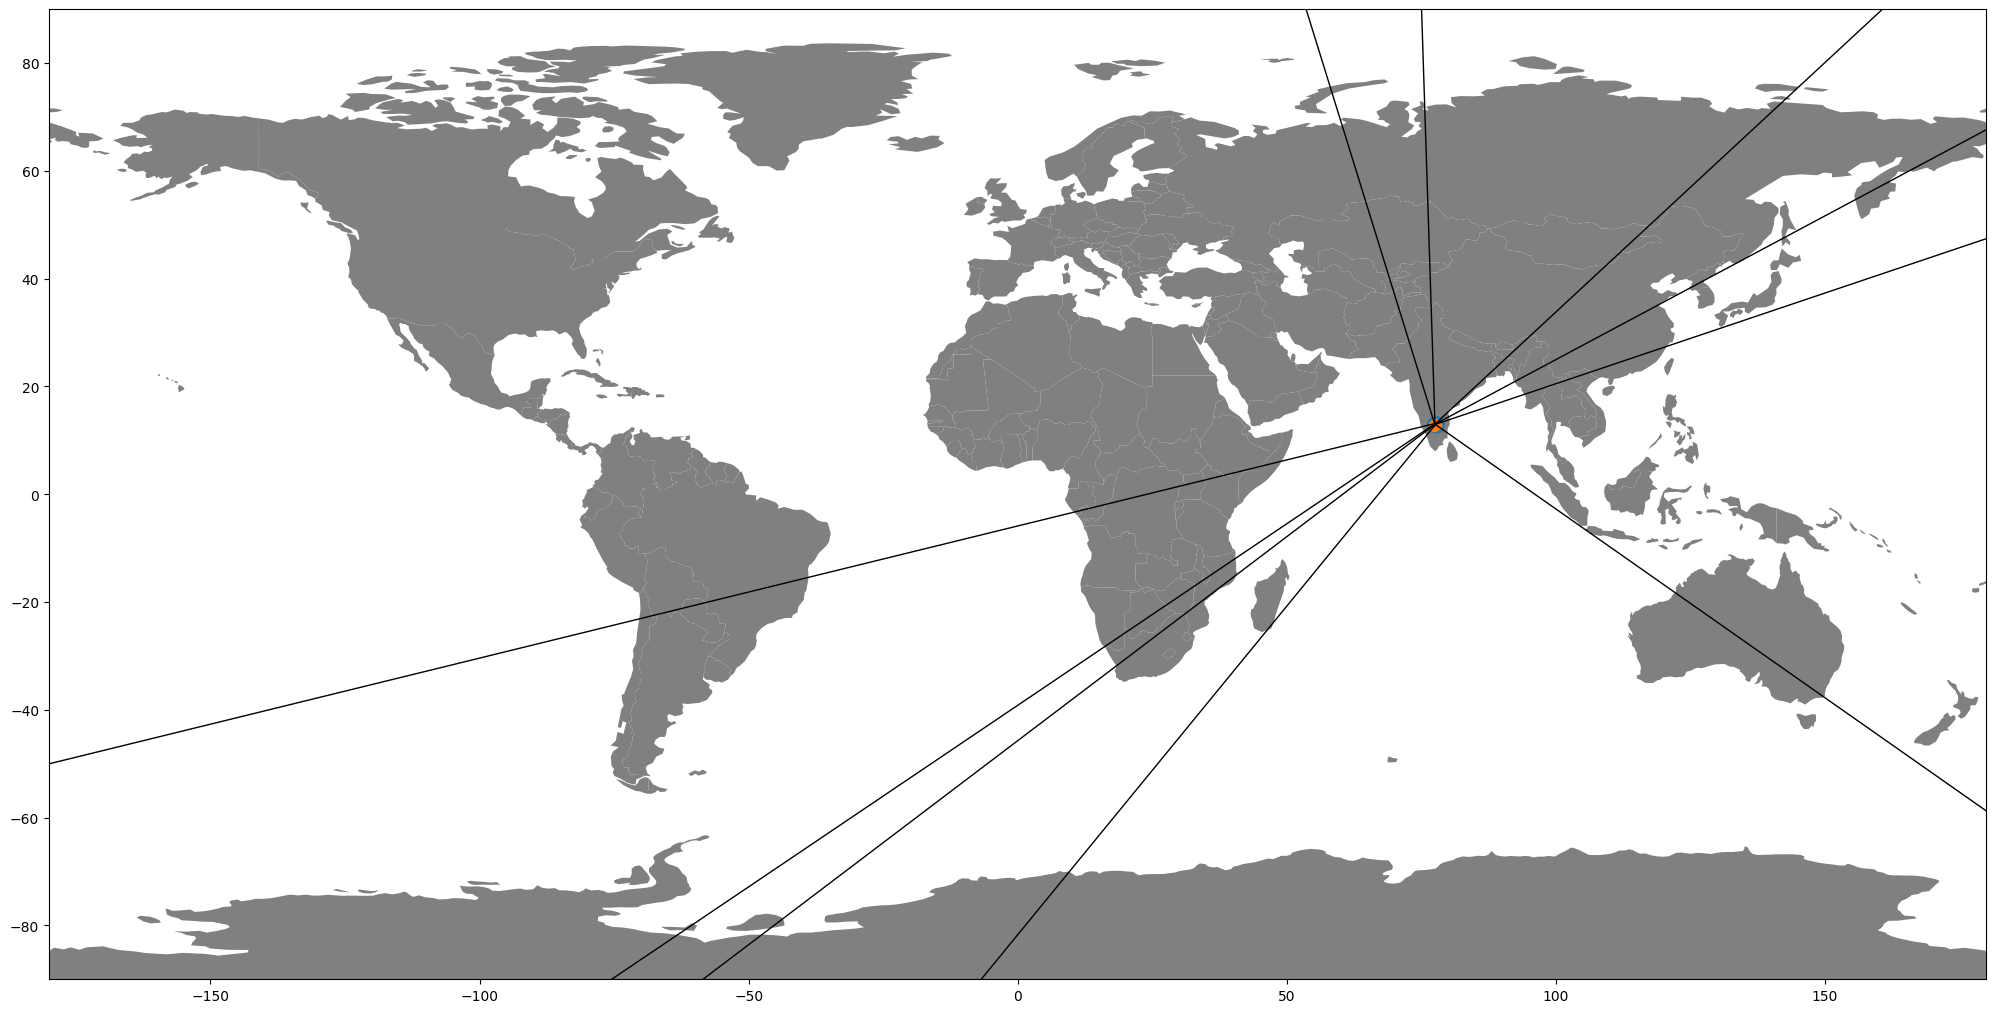

In [6]:
fig, ax = plt.subplots(figsize=(25, 25))
world.plot(ax=ax, color="gray")
voronoi_plot_2d(vor, ax, point_size=20)
plt.xlim((-180, 180))
plt.ylim((-90, 90))
plt.show()